# Dataset Sparsity Analysis

This notebook analyzes the sparsity characteristics of bioresponse and hiva_agnostic datasets, and examines the target variable ranges for qsar-tid-11. This helps explain why feature selection methods work differently across these datasets.

In [77]:
# Import required libraries
import openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [78]:
def load_dataset(openml_id):
    """
    Args:
    - openml_id(str): Task ID or dataset name
    """
    try:
        task_id = int(openml_id)
        task = openml.tasks.get_task(task_id)
    except ValueError:
        dataset_list = openml.datasets.list_datasets(output_format="dataframe")
        matching = dataset_list[dataset_list['name'] == openml_id]
        if matching.empty:
            raise ValueError(f"No OpenML dataset found with name '{openml_id}'")
        dataset_id = matching.iloc[0]['did']
        task_list = openml.tasks.list_tasks(output_format="dataframe", dataset=dataset_id)
        if task_list.empty:
            raise ValueError(f"No tasks found for dataset '{openml_id}'")
        task_id = task_list.iloc[0]['tid'] # first matching task
        task = openml.tasks.get_task(task_id)

    dataset = task.get_dataset()
    return task, dataset

In [79]:
def analyze_sparsity(X, dataset_name):
    """Sparsity analysis that treats '0'/'1' strings as numeric and counts zeros properly."""
    import numpy as np
    import pandas as pd

    # Ensure DataFrame
    if not hasattr(X, "dtypes"):
        X = pd.DataFrame(X)

    n_samples, n_features = X.shape
    total_elements = max(n_samples * n_features, 1)

    # NaNs across all columns (works with mixed dtypes)
    nan_mask = X.isna().to_numpy()
    nan_count = int(nan_mask.sum())

    # Coerce numeric-like columns (e.g., '0','1','0.0') to numbers for zero counting
    # Non-numeric strings become NaN here (we won't count them as zero)
    X_num = X.apply(pd.to_numeric, errors="coerce")

    # Zeros on any column that successfully coerced to numeric
    zero_mask = (X_num == 0).to_numpy()
    zero_count = int(zero_mask.sum())

    # Combined sparsity: zeros (from numeric-like) OR NaNs (from original)
    sparse_mask = zero_mask | nan_mask
    total_sparsity = (zero_count + nan_count) / total_elements

    feature_sparsity = sparse_mask.mean(axis=0)
    sample_sparsity  = sparse_mask.mean(axis=1)

    # Non-zero numeric values for value distribution
    nz_vals = X_num.to_numpy()
    non_zero_values = nz_vals[(~np.isnan(nz_vals)) & (nz_vals != 0)]

    print(f"\n{'='*50}")
    print(f"SPARSITY ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    print(f"\nDataset Dimensions:")
    print(f"  Samples: {n_samples:,}")
    print(f"  Features: {n_features:,}")
    print(f"  Total elements: {n_samples*n_features:,}")

    print(f"\nOverall Sparsity:")
    print(f"  Zero values (numeric-like cols): {zero_count:,} ({zero_count/total_elements:.2%})")
    print(f"  NaN/Missing values (all cols):   {nan_count:,} ({nan_count/total_elements:.2%})")
    print(f"  Total sparse elements:           {zero_count + nan_count:,} ({total_sparsity:.2%})")
    print(f"  Non-sparse elements:             {n_samples*n_features - zero_count - nan_count:,} ({1-total_sparsity:.2%})")

    print(f"\nFeature-wise Sparsity:")
    print(f"  Features with >50% sparse: {int((feature_sparsity > 0.5).sum()):,}")
    print(f"  Features with >90% sparse: {int((feature_sparsity > 0.9).sum()):,}")
    print(f"  Features with >99% sparse: {int((feature_sparsity > 0.99).sum()):,}")
    print(f"  Mean feature sparsity: {feature_sparsity.mean():.2%}")
    print(f"  Median feature sparsity: {np.median(feature_sparsity):.2%}")

    print(f"\nSample-wise Sparsity:")
    print(f"  Samples with >50% sparse: {int((sample_sparsity > 0.5).sum()):,}")
    print(f"  Samples with >90% sparse: {int((sample_sparsity > 0.9).sum()):,}")
    print(f"  Mean sample sparsity: {sample_sparsity.mean():.2%}")
    print(f"  Median sample sparsity: {np.median(sample_sparsity):.2%}")

    if non_zero_values.size:
        print(f"\nNon-zero Numeric Value Distribution:")
        print(f"  Min: {np.min(non_zero_values):.4f}")
        print(f"  Max: {np.max(non_zero_values):.4f}")
        print(f"  Mean: {np.mean(non_zero_values):.4f}")
        print(f"  Median: {np.median(non_zero_values):.4f}")
        print(f"  Std: {np.std(non_zero_values):.4f}")

    return {
        "dataset_name": dataset_name,
        "n_samples": n_samples,
        "n_features": n_features,
        "zero_sparsity": zero_count/total_elements,
        "nan_sparsity": nan_count/total_elements,
        "total_sparsity": total_sparsity,
        "feature_sparsity": feature_sparsity,
        "sample_sparsity": sample_sparsity,
        "non_zero_values": non_zero_values,
    }

In [80]:
def plot_sparsity_analysis(sparsity_results):
    """Create visualizations for sparsity analysis"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f"Sparsity Analysis: {sparsity_results['dataset_name']}", fontsize=16)
    
    # Feature sparsity distribution
    axes[0, 0].hist(sparsity_results['feature_sparsity'], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Feature Sparsity')
    axes[0, 0].set_ylabel('Number of Features')
    axes[0, 0].set_title('Distribution of Feature Sparsity')
    axes[0, 0].axvline(np.mean(sparsity_results['feature_sparsity']), color='red', 
                      linestyle='--', label=f'Mean: {np.mean(sparsity_results["feature_sparsity"]):.2%}')
    axes[0, 0].legend()
    
    # Sample sparsity distribution
    axes[0, 1].hist(sparsity_results['sample_sparsity'], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Sample Sparsity')
    axes[0, 1].set_ylabel('Number of Samples')
    axes[0, 1].set_title('Distribution of Sample Sparsity')
    axes[0, 1].axvline(np.mean(sparsity_results['sample_sparsity']), color='red', 
                      linestyle='--', label=f'Mean: {np.mean(sparsity_results["sample_sparsity"]):.2%}')
    axes[0, 1].legend()
    
    # Non-zero values distribution
    if len(sparsity_results['non_zero_values']) > 0:
        # Use log scale if values span many orders of magnitude
        non_zero_vals = sparsity_results['non_zero_values']
        if np.max(non_zero_vals) / np.min(non_zero_vals) > 1000:
            axes[1, 0].hist(np.log10(np.abs(non_zero_vals) + 1e-10), bins=50, alpha=0.7, edgecolor='black')
            axes[1, 0].set_xlabel('Log10(|Non-zero Values|)')
            axes[1, 0].set_title('Distribution of Non-zero Values (Log Scale)')
        else:
            axes[1, 0].hist(non_zero_vals, bins=50, alpha=0.7, edgecolor='black')
            axes[1, 0].set_xlabel('Non-zero Values')
            axes[1, 0].set_title('Distribution of Non-zero Values')
        axes[1, 0].set_ylabel('Frequency')
    
    # Sparsity summary bar plot
    categories = ['Zero Values', 'NaN Values', 'Non-sparse Values']
    values = [sparsity_results['zero_sparsity'], 
              sparsity_results['nan_sparsity'], 
              1 - sparsity_results['total_sparsity']]
    colors = ['lightcoral', 'lightsalmon', 'lightblue']
    
    bars = axes[1, 1].bar(categories, values, color=colors, edgecolor='black')
    axes[1, 1].set_ylabel('Proportion of Total Elements')
    axes[1, 1].set_title('Overall Data Composition')
    axes[1, 1].set_ylim(0, 1)
    
    # Add percentage labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.2%}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [81]:
def analyze_target_ranges(y, dataset_name):
    """Analyze target variable ranges"""
    
    print(f"\n{'='*50}")
    print(f"TARGET ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    if hasattr(y, 'values'):
        y_array = y.values.ravel()
    else:
        y_array = np.array(y).ravel()
    
    # Remove NaN values for analysis
    y_clean = y_array[~np.isnan(y_array)]
    
    print(f"\nTarget Variable Statistics:")
    print(f"  Total samples: {len(y_array):,}")
    print(f"  Non-NaN samples: {len(y_clean):,}")
    print(f"  NaN values: {len(y_array) - len(y_clean):,}")
    
    if len(y_clean) > 0:
        print(f"\nValue Range:")
        print(f"  Minimum: {np.min(y_clean):.6f}")
        print(f"  Maximum: {np.max(y_clean):.6f}")
        print(f"  Range: {np.max(y_clean) - np.min(y_clean):.6f}")
        print(f"  Mean: {np.mean(y_clean):.6f}")
        print(f"  Median: {np.median(y_clean):.6f}")
        print(f"  Std: {np.std(y_clean):.6f}")
        
        # Check if binary classification
        unique_vals = np.unique(y_clean)
        print(f"\nUnique Values: {len(unique_vals)}")
        if len(unique_vals) <= 10:
            print(f"  Values: {unique_vals}")
            print(f"  Counts: {[np.sum(y_clean == val) for val in unique_vals]}")
            
    return y_clean

## Load and Analyze Bioresponse Dataset

In [82]:
print("Loading bioresponse dataset...")
try:
    task_bio, dataset_bio = load_dataset('363620')
    X_bio, y_bio, categorical_indicator_bio, attribute_names_bio = dataset_bio.get_data(
        dataset_format="dataframe", 
        target=dataset_bio.default_target_attribute
    )
    
    print(f"Successfully loaded bioresponse!")
    print(f"Shape: {X_bio.shape}")
    
except Exception as e:
    print(f"Error loading bioresponse: {str(e)}")
    X_bio, y_bio = None, None

Loading bioresponse dataset...


Successfully loaded bioresponse!
Shape: (3751, 1776)


In [94]:
y = y_bio if isinstance(y_bio, pd.Series) else pd.Series(y_bio)

# unique class labels (drop NaNs)
classes = y.dropna().unique()
print("Classes:", classes)

# with counts
print(y.value_counts(dropna=False))

Classes: ['Yes', 'No']
Categories (2, object): ['No', 'Yes']
MoleculeElicitsResponse
Yes    2034
No     1717
Name: count, dtype: int64


In [83]:
# Analyze bioresponse sparsity
if X_bio is not None:
    bioresponse_results = analyze_sparsity(X_bio, 'bioresponse')


SPARSITY ANALYSIS: BIORESPONSE

Dataset Dimensions:
  Samples: 3,751
  Features: 1,776
  Total elements: 6,661,776

Overall Sparsity:
  Zero values (numeric-like cols): 5,593,148 (83.96%)
  NaN/Missing values (all cols):   0 (0.00%)
  Total sparse elements:           5,593,148 (83.96%)
  Non-sparse elements:             1,068,628 (16.04%)

Feature-wise Sparsity:
  Features with >50% sparse: 1,596
  Features with >90% sparse: 1,126
  Features with >99% sparse: 252
  Mean feature sparsity: 83.96%
  Median feature sparsity: 94.76%

Sample-wise Sparsity:
  Samples with >50% sparse: 3,751
  Samples with >90% sparse: 642
  Mean sample sparsity: 83.96%
  Median sample sparsity: 85.25%

Non-zero Numeric Value Distribution:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.5478
  Median: 0.5188
  Std: 0.4105


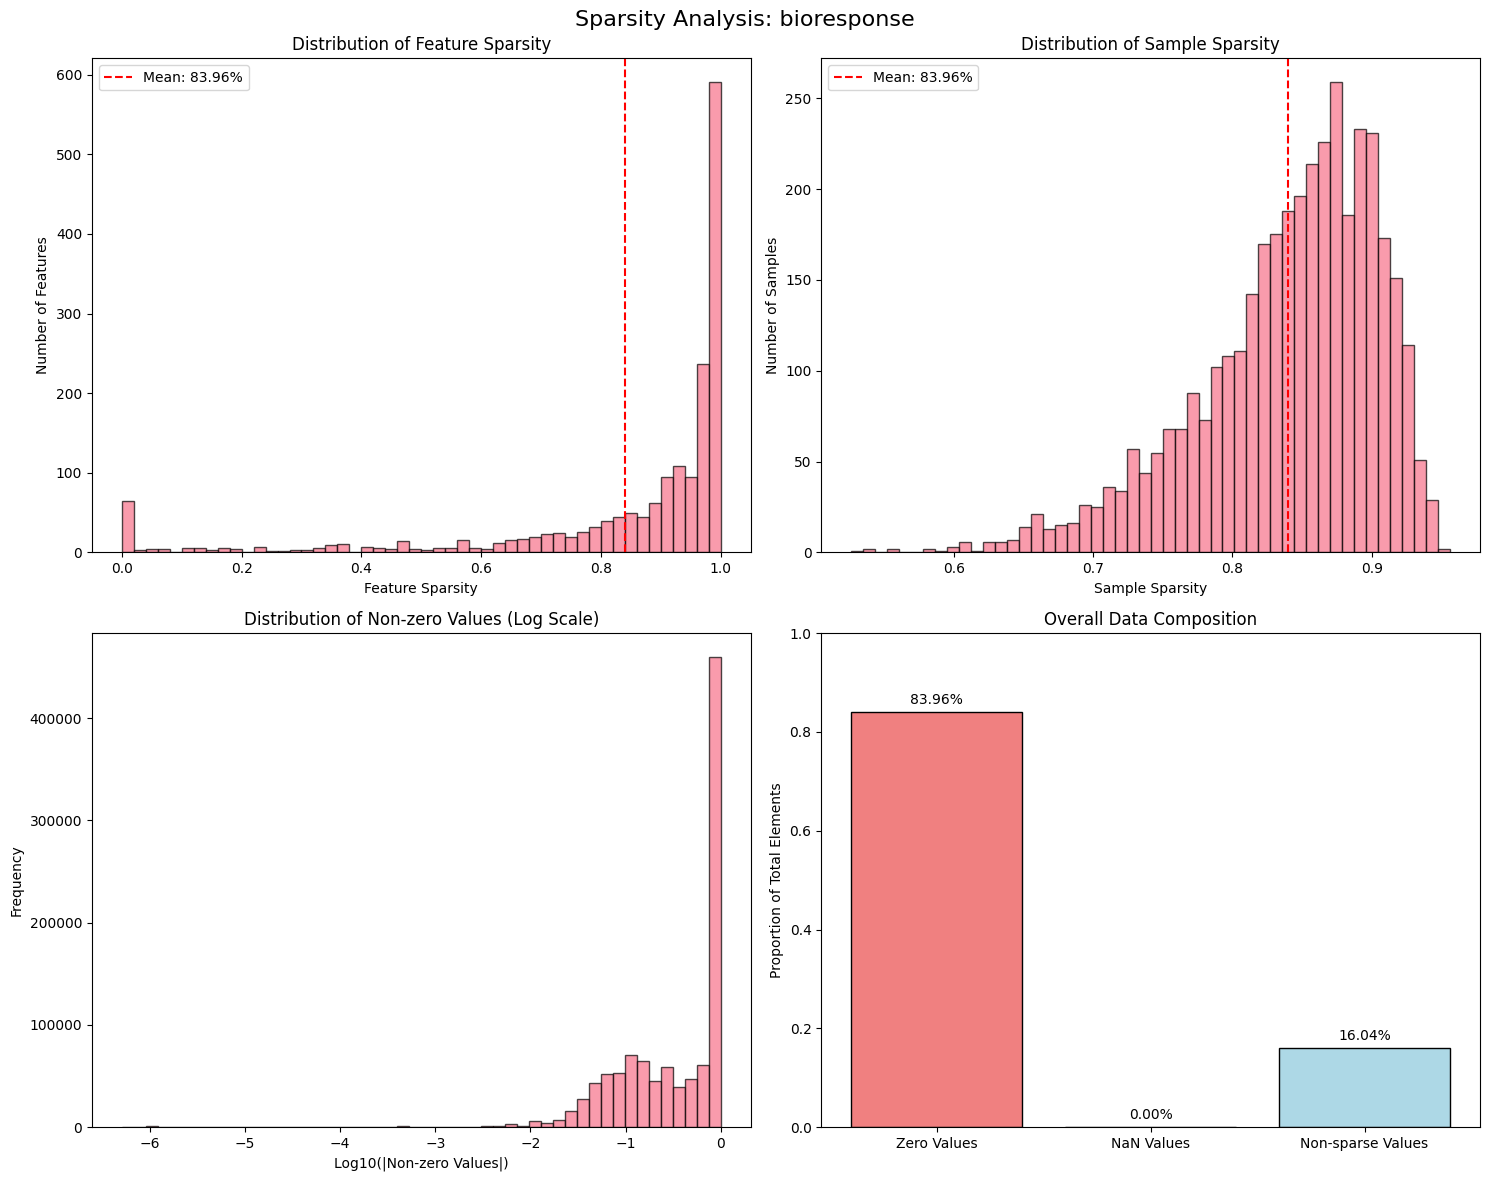

In [84]:
# Plot bioresponse sparsity analysis
if X_bio is not None:
    plot_sparsity_analysis(bioresponse_results)

## Load and Analyze HIVA-Agnostic Dataset

In [85]:
print("Loading hiva_agnostic dataset...")
try:
    task_hiva, dataset_hiva = load_dataset('363677')
    X_hiva, y_hiva, categorical_indicator_hiva, attribute_names_hiva = dataset_hiva.get_data(
        dataset_format="dataframe", 
        target=dataset_hiva.default_target_attribute
    )
    
    print(f"Successfully loaded hiva_agnostic!")
    print(f"Shape: {X_hiva.shape}")
    
except Exception as e:
    print(f"Error loading hiva_agnostic: {str(e)}")
    X_hiva, y_hiva = None, None

Loading hiva_agnostic dataset...


Successfully loaded hiva_agnostic!
Shape: (3845, 1617)


In [93]:
# ensure Series
y = y_hiva if isinstance(y_hiva, pd.Series) else pd.Series(y_hiva)

# unique class labels (drop NaNs)
classes = y.dropna().unique()
print("Classes:", classes)

# with counts
print(y.value_counts(dropna=False))

Classes: ['CM', 'CI', 'CA']
Categories (3, object): ['CA', 'CI', 'CM']
CompoundActivity
CI    3710
CM      93
CA      42
Name: count, dtype: int64


In [86]:
# Analyze hiva_agnostic sparsity
if X_hiva is not None:
    hiva_results = analyze_sparsity(X_hiva, 'hiva_agnostic')


SPARSITY ANALYSIS: HIVA_AGNOSTIC

Dataset Dimensions:
  Samples: 3,845
  Features: 1,617
  Total elements: 6,217,365

Overall Sparsity:
  Zero values (numeric-like cols): 5,652,411 (90.91%)
  NaN/Missing values (all cols):   0 (0.00%)
  Total sparse elements:           5,652,411 (90.91%)
  Non-sparse elements:             564,954 (9.09%)

Feature-wise Sparsity:
  Features with >50% sparse: 1,573
  Features with >90% sparse: 1,246
  Features with >99% sparse: 110
  Mean feature sparsity: 90.91%
  Median feature sparsity: 95.76%

Sample-wise Sparsity:
  Samples with >50% sparse: 3,845
  Samples with >90% sparse: 2,414
  Mean sample sparsity: 90.91%
  Median sample sparsity: 91.40%

Non-zero Numeric Value Distribution:
  Min: 1.0000
  Max: 1.0000
  Mean: 1.0000
  Median: 1.0000
  Std: 0.0000


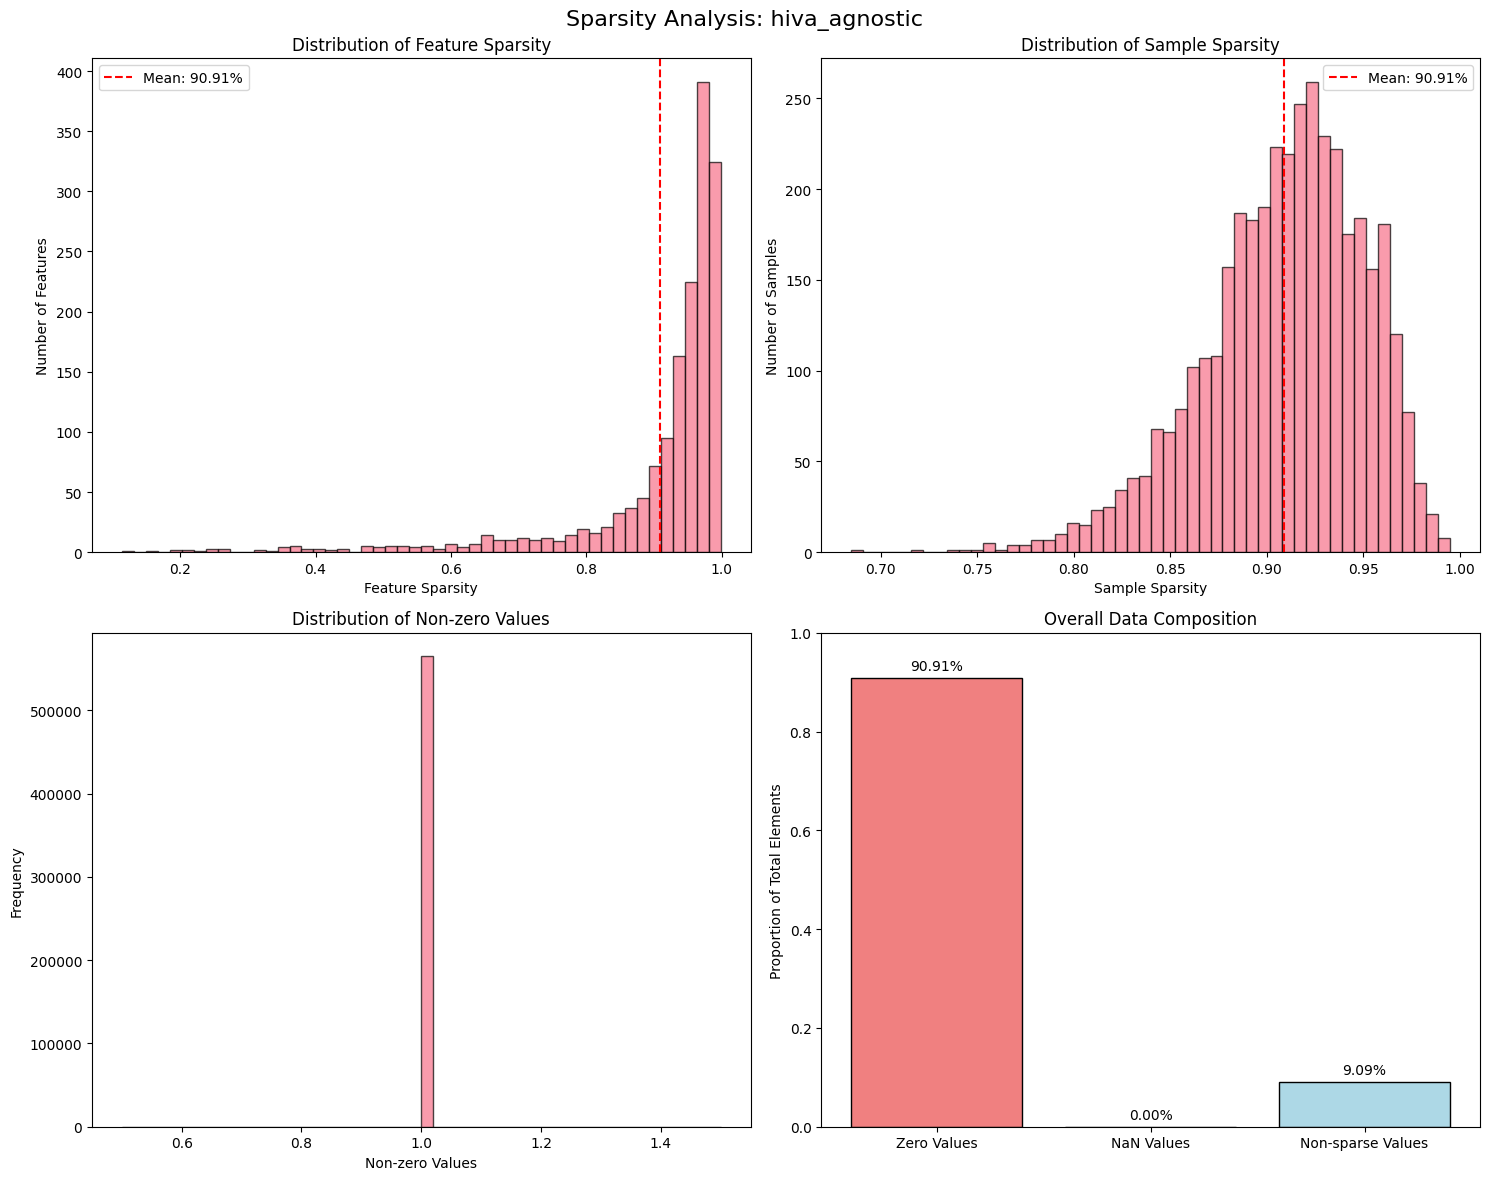

In [88]:
# Plot hiva_agnostic sparsity analysis
if X_hiva is not None:
    plot_sparsity_analysis(hiva_results)

## Load and Analyze QSAR-TID-11 Target Variable

In [89]:
print("Loading qsar-tid-11 dataset...")
try:
    task_qsar, dataset_qsar = load_dataset('363697')
    X_qsar, y_qsar, categorical_indicator_qsar, attribute_names_qsar = dataset_qsar.get_data(
        dataset_format="dataframe", 
        target=dataset_qsar.default_target_attribute
    )
    
    print(f"Successfully loaded qsar-tid-11!")
    print(f"Shape: {X_qsar.shape}")
    
except Exception as e:
    print(f"Error loading qsar-tid-11: {str(e)}")
    X_qsar, y_qsar = None, None

Loading qsar-tid-11 dataset...
Successfully loaded qsar-tid-11!
Shape: (5742, 1024)


In [90]:
# Analyze qsar-tid-11 target ranges
if y_qsar is not None:
    y_qsar_clean = analyze_target_ranges(y_qsar, 'qsar-tid-11')


TARGET ANALYSIS: QSAR-TID-11

Target Variable Statistics:
  Total samples: 5,742
  Non-NaN samples: 5,742
  NaN values: 0

Value Range:
  Minimum: -6.240000
  Maximum: 11.000000
  Range: 17.240000
  Mean: 6.237024
  Median: 5.889000
  Std: 1.547525

Unique Values: 1387


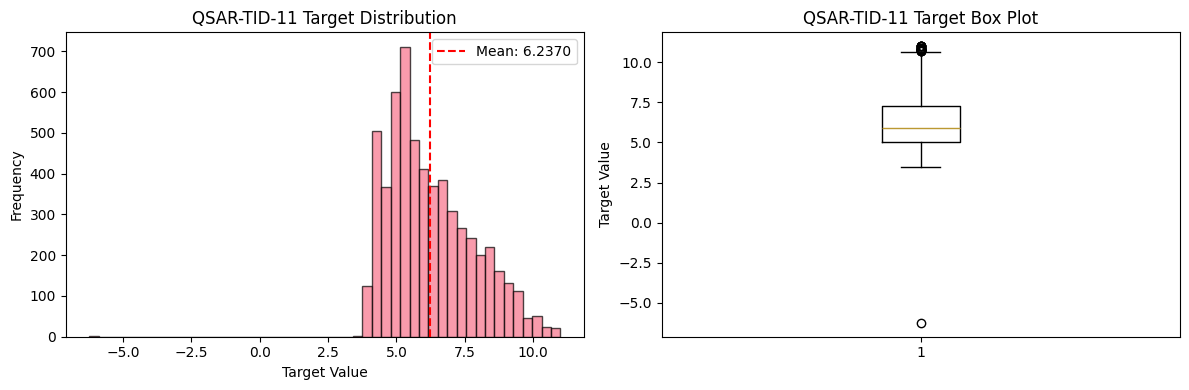

In [91]:
# Plot target distribution for qsar-tid-11
if y_qsar is not None:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(y_qsar_clean, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Target Value')
    plt.ylabel('Frequency')
    plt.title('QSAR-TID-11 Target Distribution')
    plt.axvline(np.mean(y_qsar_clean), color='red', linestyle='--', label=f'Mean: {np.mean(y_qsar_clean):.4f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.boxplot(y_qsar_clean)
    plt.ylabel('Target Value')
    plt.title('QSAR-TID-11 Target Box Plot')
    
    plt.tight_layout()
    plt.show()

## Comparison Summary

In [92]:
# Create comparison summary
results = {}
if 'bioresponse_results' in locals():
    results['bioresponse'] = bioresponse_results
if 'hiva_results' in locals():
    results['hiva_agnostic'] = hiva_results

if len(results) > 1:
    print(f"\n{'='*50}")
    print("SPARSITY COMPARISON SUMMARY")
    print(f"{'='*50}")
    
    comparison_df = pd.DataFrame({
        name: {
            'Samples': result['n_samples'],
            'Features': result['n_features'],
            'Total Sparsity': f"{result['total_sparsity']:.2%}",
            'Zero Sparsity': f"{result['zero_sparsity']:.2%}",
            'NaN Sparsity': f"{result['nan_sparsity']:.2%}",
            'Mean Feature Sparsity': f"{np.mean(result['feature_sparsity']):.2%}",
            'Features >90% sparse': np.sum(result['feature_sparsity'] > 0.9),
            'Features >99% sparse': np.sum(result['feature_sparsity'] > 0.99)
        }
        for name, result in results.items()
    })
    
    display(comparison_df.T)
else:
    print("Could not load enough datasets for comparison.")


SPARSITY COMPARISON SUMMARY


,Samples,Features,Total Sparsity,Zero Sparsity,NaN Sparsity,Mean Feature Sparsity,Features >90% sparse,Features >99% sparse
bioresponse,3751,1776,83.96%,83.96%,0.00%,83.96%,1126,252
hiva_agnostic,3845,1617,90.91%,90.91%,0.00%,90.91%,1246,110


## Conclusions

This analysis helps explain why feature selection methods work differently across datasets:

- **High sparsity** (many zeros/missing values) often indicates noisy or irrelevant features
- **Many highly sparse features** (>90% sparse) suggest that feature selection could help
- **Dense datasets** with meaningful features may not benefit from explicit feature selection
- **Tree-based methods** like CatBoost already perform implicit feature selection, but explicit methods can still help with very sparse/noisy data